In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from keras.models import Model, load_model
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from skimage import transform
from sklearn import metrics, cluster
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

/home/can/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def bypass(x):
    return x

def h_flip(x):
    return x[:, :, ::-1, :]

def v_flip(x):
    return x[:, ::-1, :, :]

def hv_flip(x):
    return h_flip(v_flip(x))

def rot90(x):
    return np.concatenate([np.expand_dims(transform.rotate(im, 90), axis=0) for im in x], axis=0)

def rot180(x):
    return np.concatenate([np.expand_dims(transform.rotate(im, 180), axis=0) for im in x], axis=0)

def rot270(x):
    return np.concatenate([np.expand_dims(transform.rotate(im, 270), axis=0) for im in x], axis=0)

aug_funcs = [bypass, 
             h_flip, v_flip, hv_flip,
             rot90, rot180, rot270]

# Load Training Data

In [3]:
# Load the training data
# Train
df_train = pd.read_json('./data/train.json')

# Test
df_test = pd.read_json('./data/test.json')
df_test_labels = pd.read_csv('./submissions/ourbest_explorestack_2.csv')
df_test = pd.merge(df_test, df_test_labels, on='id')
iceberg_cond = (df_test['is_iceberg'] >= 0.9) & (df_test['is_iceberg'] <= 1.0)
not_iceberg_cond = (df_test['is_iceberg'] >= 0.0) & (df_test['is_iceberg'] <= 0.1)
df_test = df_test[iceberg_cond | not_iceberg_cond]

# Merge Train and Test
df = pd.concat([df_train, df_test])
df = df_train  # .. 
print len(df)

def normalize(im):
    im = im - np.mean(im)
    im = im / np.std(im)
    return im

X, y = [], []
for im_band1, im_band2, label in zip(df['band_1'], df['band_2'], df['is_iceberg']):
    im_band1 = np.array(im_band1).reshape(75, 75, 1)
    im_band2 = np.array(im_band2).reshape(75, 75, 1)    
    # Preprocess
    # - Zero mean
    im_band1 -= np.mean(im_band1)
    im_band2 -= np.mean(im_band2)
    # - Normalize
    im_band1 /= np.std(im_band1)
    im_band2 /= np.std(im_band2)    
    im = np.concatenate([im_band1, im_band2], axis=2)
#     im = np.concatenate([normalize(im_band1), normalize(im_band2), get_convolve(im_band1, im_band2)], axis=2)
    X.append(im)
    y.append(label)    
X = np.array(X)
y = np.array(y)
print 'X.shape:', X.shape
print 'y.shape:', y.shape

1604
X.shape: (1604, 75, 75, 2)
y.shape: (1604,)


# Train - Val Split 

In [4]:
N_SPLITS = 5
MODEL_NUMBER = 1
MODEL_PATH = './models/model12-v3/model' + str(MODEL_NUMBER)  + '.h5'

In [5]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_SEED, shuffle=True)
cv = list(skf.split(X, y > 0.5))

train_i, val_i = cv[MODEL_NUMBER - 1]
X_train, y_train = X[train_i], y[train_i]
X_val, y_val = X[val_i], y[val_i]
print 'X_train.shape:', X_train.shape
print 'y_train.shape:', y_train.shape
print 'X_val.shape:', X_val.shape
print 'y_val.shape:', y_val.shape
print 'np.mean(y_train):', np.mean(y_train)
print 'np.mean(y_val):', np.mean(y_val)

X_train.shape: (1282, 75, 75, 2)
y_train.shape: (1282,)
X_val.shape: (322, 75, 75, 2)
y_val.shape: (322,)
np.mean(y_train): 0.469578783151
np.mean(y_val): 0.468944099379


In [6]:
# # Train
# X_train = np.concatenate([func(X_train) for func in aug_funcs], axis=0)
# y_train = np.concatenate([y_train] * len(aug_funcs))

# # Validation
# X_val = np.concatenate([func(X_val) for func in aug_funcs], axis=0)
# y_val = np.concatenate([y_val] * len(aug_funcs))

# # 
# print 'X_train.shape:', X_train.shape
# print 'y_train.shape:', y_train.shape
# print 'X_val.shape:', X_val.shape
# print 'y_val.shape:', y_val.shape

In [7]:
# Load the model
base_model = load_model(MODEL_PATH)
base_model.layers

# Create the model
x = base_model.layers[-7].output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
model = Model(input=base_model.input, output=x)
model

/home/can/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("gl..., inputs=Tensor("co...)`
  if __name__ == '__main__':


In [8]:
# Extract the features
# Train
X_train = list(X_train)
for i, im in tqdm_notebook(enumerate(X_train)):
    im = np.expand_dims(im, axis=0)
    X_train[i] = np.squeeze(model.predict(im))
X_train = np.array(X_train)
print 'X_train.shape:', X_train.shape

# Val
X_val = list(X_val)
for i, im in tqdm_notebook(enumerate(X_val)):
    im = np.expand_dims(im, axis=0)
    X_val[i] = np.squeeze(model.predict(im))
X_val = np.array(X_val)
print 'X_val.shape:', X_val.shape

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


X_train.shape: (1282, 256)


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))


X_val.shape: (322, 256)


In [9]:
pca_model = PCA(n_components=2, random_state=RANDOM_SEED)
pca_model.fit(X_train)
X_train_r = pca_model.transform(X_train)
X_val_r = pca_model.transform(X_val)

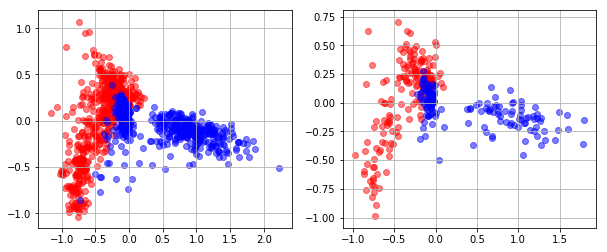

In [10]:
labels = [0, 1]
colors = ['r', 'b']
y_train_ = (y_train > 0.5).astype(np.int)
y_val_ = (y_val > 0.5).astype(np.int)

# Plot
fig = plt.figure(figsize=(10, 4))
# * Train
plt.subplot(1,2,1)
for label, color in zip(labels, colors):
    X_train_r_ = X_train_r[y_train_ == label]
    plt.scatter(X_train_r_[:, 0], X_train_r_[:, 1], c=color, alpha=0.5)
plt.grid('on')

# * Val
plt.subplot(1,2,2)
for label, color in zip(labels, colors):
    X_val_r_ = X_val_r[y_val_ == label]
    plt.scatter(X_val_r_[:, 0], X_val_r_[:, 1], c=color, alpha=0.5)
plt.grid('on')

In [11]:
# model_xgb = SVC(probability=True)
# model_xgb.fit(X_train, (y_train > 0).astype(np.int))
# y_train_p = model_xgb.predict_proba(X_train)
# y_val_p = model_xgb.predict_proba(X_val)

# print metrics.log_loss((y_train > 0).astype(np.int), y_train_p[:, 1])
# print metrics.log_loss((y_val > 0).astype(np.int), y_val_p[:, 1])

In [12]:
X_r = np.concatenate([X_train_r, X_val_r], axis=0)
y = np.concatenate([y_train, y_val])
print X.shape
print y.shape

(1604, 75, 75, 2)
(1604,)


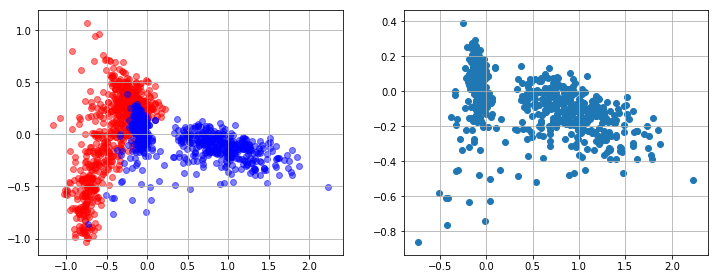

In [13]:
#
fig = plt.figure(figsize=(12, 4.5))

# Plot 1
plt.subplot(1,2,1)
labels = [0, 1]
colors = ['r', 'b']
for label, color in zip(labels, colors):
    X_ = X_r[y == label]
    plt.scatter(X_[:, 0], X_[:, 1], c=color, alpha=0.5)
plt.grid('on')

# Plot 2
plt.subplot(1,2,2)
X_ = X_r[y == 1]
plt.scatter(X_[:, 0], X_[:, 1])
plt.grid('on')

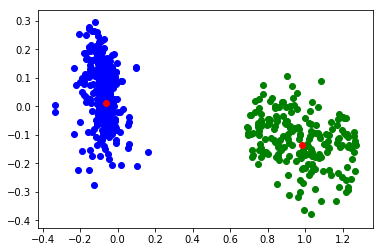

In [14]:
#
X_iceberg = X_r[y == 1]  # Get iceberg
kmeans_model = cluster.KMeans(n_clusters=2, random_state=RANDOM_SEED).fit(X_iceberg)
cluster_i = kmeans_model.predict(X_iceberg)
distances = kmeans_model.transform(X_iceberg)

#
t_dist = 0.30
b = ((cluster_i == 0) & (distances[:, 0] < t_dist)) | ((cluster_i == 1) & (distances[:, 1] < t_dist))
X_iceberg_ = X_iceberg[b]
cluster_i_ = cluster_i[b]

# Plot
fig = plt.figure()
labels = [0, 1]
colors = ['g', 'b']
for label, color in zip(labels, colors):
    X_ = X_iceberg_[cluster_i_ == label]
    plt.scatter(X_[:, 0], X_[:, 1], c=color)
cluster_centers = kmeans_model.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='r')

In [15]:
cluster_centers

array([[ 0.98313284, -0.13511895],
       [-0.06012586,  0.01264317]], dtype=float32)

In [16]:
((cluster_i == 1) & (distances[:, 1] < t_dist)).sum()

375

In [17]:
N = 16
# Cluster 0
n_cluster = 0
print cluster_centers[n_cluster]
distances = [np.sqrt(np.sum((x - cluster_centers[n_cluster]) ** 2)) for x in list(X_r)]
distances = zip(range(len(X_r)), distances) 
distances = sorted(distances, key=lambda x: x[1])
cluster0_i = [e[0] for e in distances][:N]
print 'cluster0_i:', cluster0_i

# Cluster 1
n_cluster = 1
print cluster_centers[n_cluster]
distances = [np.sqrt(np.sum((x - cluster_centers[n_cluster]) ** 2)) for x in list(X_r)]
distances = zip(range(len(X_r)), distances) 
distances = sorted(distances, key=lambda x: x[1])
cluster1_i = [e[0] for e in distances][:375]
print 'cluster1_i:', cluster1_i

[ 0.98313284 -0.13511895]
cluster0_i: [774, 972, 149, 1309, 449, 893, 950, 123, 358, 215, 1033, 876, 790, 936, 1345, 1348]
[-0.06012586  0.01264317]
cluster1_i: [846, 918, 114, 724, 1426, 62, 186, 226, 1082, 304, 1405, 386, 929, 84, 54, 1395, 1308, 1166, 1039, 687, 702, 842, 1331, 685, 220, 257, 765, 901, 960, 190, 343, 674, 1394, 1343, 1143, 942, 1435, 506, 138, 826, 513, 265, 346, 307, 766, 532, 106, 444, 1500, 1556, 388, 1548, 1369, 256, 137, 947, 566, 744, 647, 881, 250, 845, 633, 410, 1023, 1046, 1012, 1550, 964, 791, 710, 1123, 490, 603, 1380, 418, 323, 1496, 1571, 1319, 102, 31, 864, 858, 984, 433, 47, 938, 18, 73, 1559, 262, 1498, 476, 809, 141, 753, 241, 1353, 1487, 1568, 1367, 1422, 198, 1518, 366, 853, 1306, 401, 1126, 612, 771, 639, 1491, 248, 545, 224, 1001, 636, 564, 646, 113, 105, 335, 429, 57, 1125, 655, 417, 1484, 69, 997, 129, 769, 940, 361, 1095, 146, 1213, 242, 1325, 1056, 874, 835, 1288, 803, 394, 1438, 1106, 260, 1413, 719, 273, 708, 907, 411, 46, 887, 819, 1553, 

In [18]:
cluster1_i

[846,
 918,
 114,
 724,
 1426,
 62,
 186,
 226,
 1082,
 304,
 1405,
 386,
 929,
 84,
 54,
 1395,
 1308,
 1166,
 1039,
 687,
 702,
 842,
 1331,
 685,
 220,
 257,
 765,
 901,
 960,
 190,
 343,
 674,
 1394,
 1343,
 1143,
 942,
 1435,
 506,
 138,
 826,
 513,
 265,
 346,
 307,
 766,
 532,
 106,
 444,
 1500,
 1556,
 388,
 1548,
 1369,
 256,
 137,
 947,
 566,
 744,
 647,
 881,
 250,
 845,
 633,
 410,
 1023,
 1046,
 1012,
 1550,
 964,
 791,
 710,
 1123,
 490,
 603,
 1380,
 418,
 323,
 1496,
 1571,
 1319,
 102,
 31,
 864,
 858,
 984,
 433,
 47,
 938,
 18,
 73,
 1559,
 262,
 1498,
 476,
 809,
 141,
 753,
 241,
 1353,
 1487,
 1568,
 1367,
 1422,
 198,
 1518,
 366,
 853,
 1306,
 401,
 1126,
 612,
 771,
 639,
 1491,
 248,
 545,
 224,
 1001,
 636,
 564,
 646,
 113,
 105,
 335,
 429,
 57,
 1125,
 655,
 417,
 1484,
 69,
 997,
 129,
 769,
 940,
 361,
 1095,
 146,
 1213,
 242,
 1325,
 1056,
 874,
 835,
 1288,
 803,
 394,
 1438,
 1106,
 260,
 1413,
 719,
 273,
 708,
 907,
 411,
 46,
 887,
 819,
 1553,
 1

In [19]:
np.save('./mislabelledships.npy', cluster1_i)

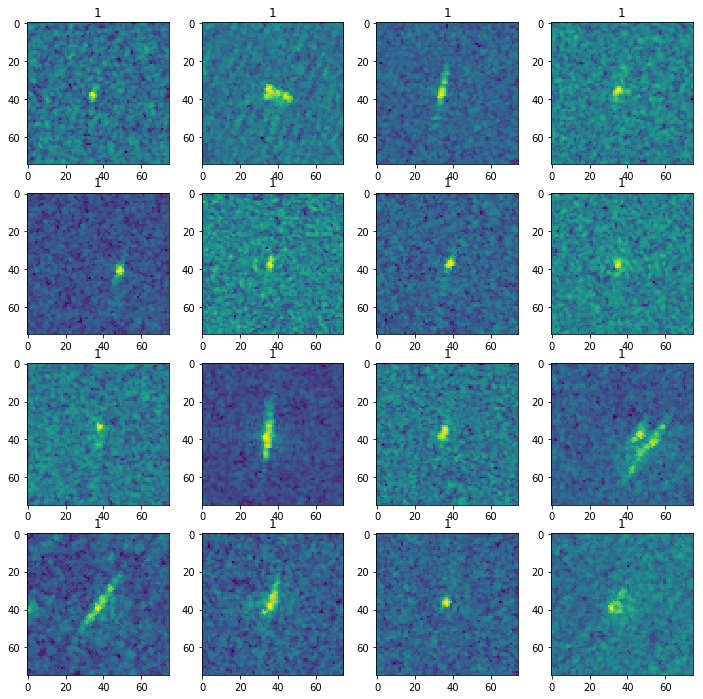

In [20]:
# Plot cluster 0
fig = plt.figure(figsize=(12, 12))
for i, c_i in enumerate(cluster0_i):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[c_i, ..., 0])
    plt.title(y[c_i])

ValueError: num must be 1 <= num <= 16, not 17

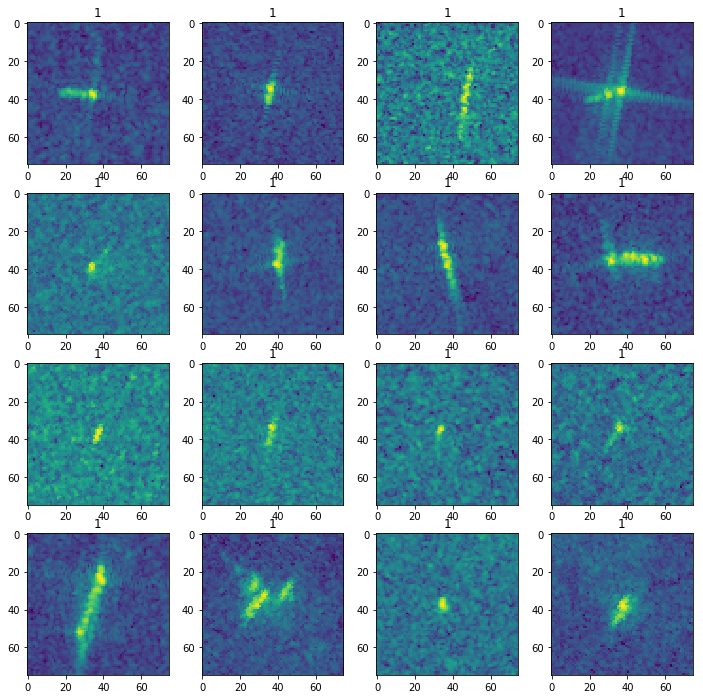

In [21]:
# Plot cluster 1
fig = plt.figure(figsize=(12, 12))
for i, c_i in enumerate(cluster1_i):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X[c_i, ..., 0])
    plt.title(y[c_i])

In [5]:
mislabelledships = np.load('./mislabelledships.npy')
len(mislabelledships)

375

In [6]:
df_mislabelledships = df.iloc[mislabelledships]
df_mislabelledships

,band_1,band_2,id,inc_angle,is_iceberg
846,"[-14.77664, -14.854605, -15.674702, -14.776833...","[-22.505844, -23.719864, -23.296143, -21.78179...",77c4d851,36.55,0
918,"[-31.669806, -32.912811, -32.912853, -28.74737...","[-32.26907, -31.669849, -30.582743, -29.171165...",b1a2ef1f,42.5128,0
114,"[-28.159935, -30.926027, -27.049665, -23.64447...","[-26.708923, -29.433355, -29.903015, -27.77394...",35053475,45.1181,0
724,"[-22.554134, -21.29838, -20.970631, -23.797272...","[-27.318918, -26.370487, -26.675343, -26.67540...",a2d9739d,38.1493,0
1426,"[-17.90897, -18.82419, -18.82419, -16.983112, ...","[-23.505783, -23.715162, -23.715162, -23.71523...",b32332c7,34.4721,1
62,"[-17.108082, -17.647697, -17.536993, -15.66495...","[-24.860067, -24.363539, -26.546375, -26.24152...",7e02f2d0,38.9177,0
186,"[-16.87038, -16.395554, -13.98961, -14.796406,...","[-23.18881, -27.558643, -26.914883, -24.731924...",c22499f6,35.7863,0
226,"[-20.415087, -22.393553, -21.620924, -17.33302...","[-27.104164, -25.235689, -22.807205, -23.93678...",892d81f6,44.5862,0
1082,"[-14.96264, -15.128144, -14.88119, -16.006363,...","[-27.169289, -25.641577, -22.213709, -22.02696...",047bb667,39.5508,0
304,"[-27.380896, -26.685692, -25.157963, -22.31586...","[-25.737162, -28.540773, -27.026396, -25.44281...",8996737e,45.3704,0


/home/can/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

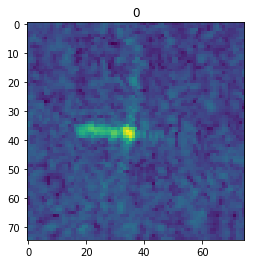

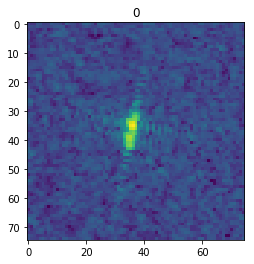

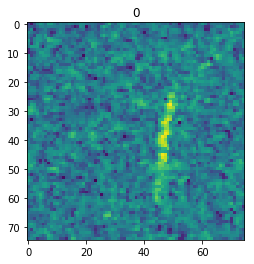

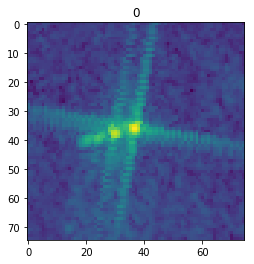

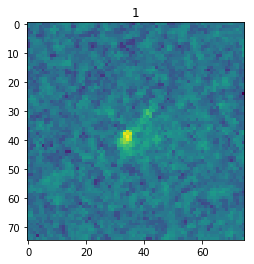

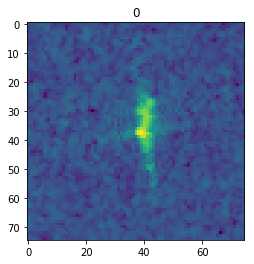

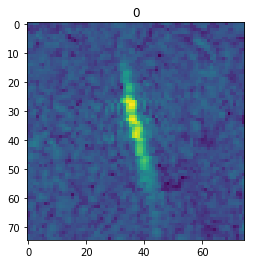

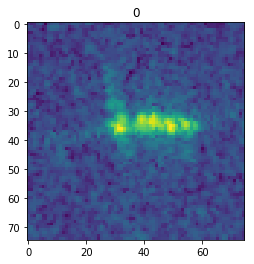

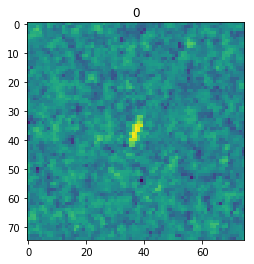

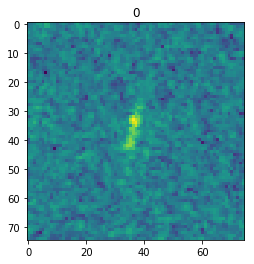

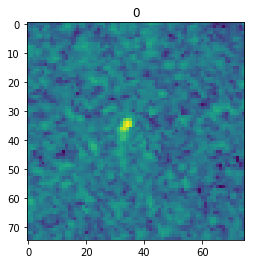

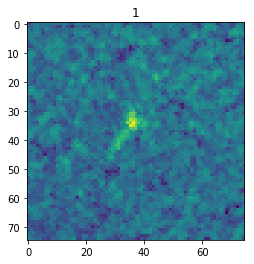

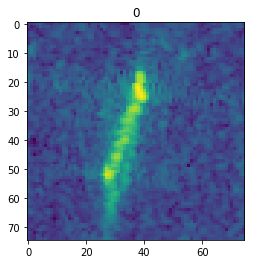

In [ ]:
for row in df_mislabelledships.iterrows():
    im, label = row[1]['band_1'], row[1]['is_iceberg']
    im = np.array(im).reshape(75, 75)
    # Plot
    fig = plt.figure()
    plt.imshow(im);
    plt.title(str(label))

In [7]:
df_mislabelledships['is_iceberg'].value_counts()

0    206
1    169
Name: is_iceberg, dtype: int64